<a href="https://colab.research.google.com/github/TMulosmani/RetinalOCTTransferLearningResNet/blob/main/RetinalOCTResNet18.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using transfer learning with ResNet18 in PyTorch to classify retinal damage from OCT Scans


## About Retinal OCT

*Quoted from https://www.kaggle.com/paultimothymooney/kermany2018 *

Retinal optical coherence tomography (OCT) is an imaging technique used to capture high-resolution cross sections of the retinas of living patients. Approximately 30 million OCT scans are performed each year, and the analysis and interpretation of these images takes up a significant amount of time (Swanson and Fujimoto, 2017).

![Figure 2](https://i.imgur.com/fSTeZMd.png)

Figure 2. Representative Optical Coherence Tomography Images and the Workflow Diagram [Kermany et. al. 2018] http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

(A) (Far left) choroidal neovascularization (CNV) with neovascular membrane (white arrowheads) and associated subretinal fluid (arrows). (Middle left) Diabetic macular edema (DME) with retinal-thickening-associated intraretinal fluid (arrows). (Middle right) Multiple drusen (arrowheads) present in early AMD. (Far right) Normal retina with preserved foveal contour and absence of any retinal fluid/edema.

## Implementation

Packages

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import copy
import os 
import random


gpu_available = torch.cuda.is_available()
if gpu_available:
  print("Using CUDA")
else: 
  print("Using CPU")

Using CUDA


# Prepare dataset 

### Get the dataset.zip from google drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

!unzip "/content/drive/MyDrive/KaggleRetinalOCTDataset.zip" -d "/content/data"  > /dev/null

Mounted at /content/drive


In [3]:
#get rid of extra folder 
!rm -rf "/content/data/oct2017"

#check data dir
os.listdir("/content/data/OCT2017 ")

['train', 'val', 'test']

## View class distribution in training set

In [2]:
class_amounts = {'DRUSEN': 0, 'DME': 0, 'NORMAL':0, 'CNV':0}

for folder in os.listdir("/content/data/OCT2017 /train"):
  folder_path = os.path.join("/content/data/OCT2017 /train", folder)
  count = 0
  # Iterate directory
  for image_path in os.listdir(folder_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(folder_path, image_path)):
        count += 1 
  
  class_amounts[folder] = count

class_amounts

{'DRUSEN': 8616, 'DME': 8616, 'NORMAL': 8616, 'CNV': 8616}

#### Plot the class distribution

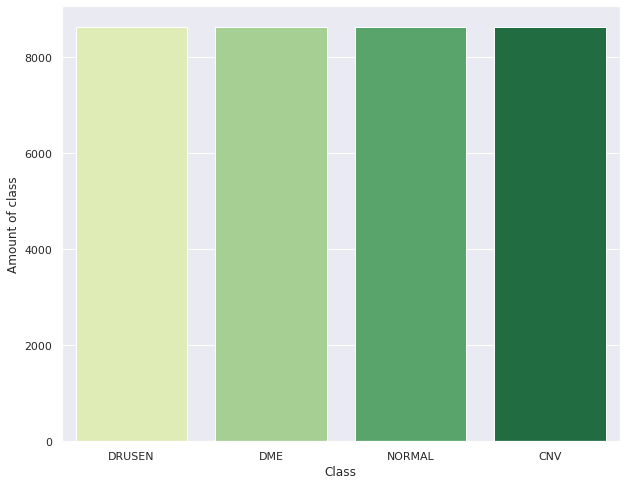

In [3]:
import seaborn as sns

keys = list(class_amounts.keys())
# get values in the same order as keys, and parse percentage values
vals = [class_amounts[k] for k in keys]

sns.set(rc={'figure.figsize':(10,8)})
sns.barplot(x=keys, y=vals, palette = "YlGn")
plt.xlabel("Class")
plt.ylabel("Amount of class")
plt.show()

#### Make dataset balanced

We do this by setting the amount of images for each class to the amount of images that the smallest class has

Could also be solved with data augmentation, but I have enough images of each class in this case

In [4]:
minimum_class_amount = min(class_amounts.values()) #8616, or "DRUSEN" class

for folder in os.listdir("/content/data/OCT2017 /train"):
  if folder != "DRUSEN":  # set the amount of images of each class to the amount the smallest class has (to balance the dataset)
    #only keep minimum_class_amount of images
    extra_images = os.listdir(os.path.join("/content/data/OCT2017 /train", folder))[0:-minimum_class_amount]
    for extra_image in extra_images:
      os.remove(os.path.join("/content/data/OCT2017 /train",folder, extra_image))

### Check to see if the dataset is balanced now

In [5]:
class_amounts = {'DRUSEN': 0, 'DME': 0, 'NORMAL':0, 'CNV':0}

for folder in os.listdir("/content/data/OCT2017 /train"):
  folder_path = os.path.join("/content/data/OCT2017 /train", folder)
  count = 0
  # Iterate directory
  for image_path in os.listdir(folder_path):
    # check if current path is a file
    if os.path.isfile(os.path.join(folder_path, image_path)):
        count += 1 
  
  class_amounts[folder] = count

class_amounts

{'DRUSEN': 8616, 'DME': 8616, 'NORMAL': 8616, 'CNV': 8616}

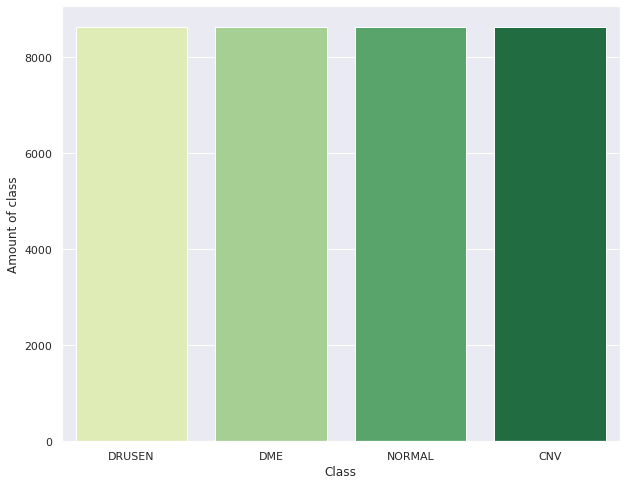

In [6]:
keys = list(class_amounts.keys())
# get values in the same order as keys, and parse percentage values
vals = [class_amounts[k] for k in keys]

sns.set(rc={'figure.figsize':(10,8)})
sns.barplot(x=keys, y=vals, palette = "YlGn")
plt.xlabel("Class")
plt.ylabel("Amount of class")
plt.show()

## View pixel distribution in training set

### Create dataset

In [7]:
data_dir = '../content/data/OCT2017 '

#data_dir is divided intro train, val, and test images 
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

data_transforms = {
    TRAIN: transforms.Compose([
        # EfficientNetV2 Takes 384*384 images as input, so here we resize the images (from documentation here https://github.com/pytorch/vision/blob/main/torchvision/models/efficientnet.py)
        transforms.Resize([384,384]),
        transforms.ToTensor(),
    ]),
    VAL: transforms.Compose([
        transforms.Resize([384,384]),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize([384,384]),
        transforms.ToTensor()
    ])
}


#create imagefolders for each dataset 
#kaggle data is already in imagefolder format, (folder name being class), so I used Imagefolder format
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), #path to data
        transform=data_transforms[x]  #transforms on the data
    )
    for x in [TRAIN, VAL, TEST]
}

#create dataloader for each dataset
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=2
    )
    for x in [TRAIN, VAL, TEST]
}


for dataset in image_datasets:
    print("Loaded {} images under {}".format(len(image_datasets[dataset]),dataset))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 34464 images under train
Loaded 32 images under val
Loaded 968 images under test
Classes: 
['CNV', 'DME', 'DRUSEN', 'NORMAL']


### Calculate the batch mean and std

In [8]:
from tqdm import tqdm


def batch_mean_and_std(loader):
    
    cnt = 0
    fst_moment = torch.empty(3)
    snd_moment = torch.empty(3)

    for images, _ in tqdm(loader):
        
        b, c, h, w = images.shape
        nb_pixels = b * h * w
        sum_ = torch.sum(images, dim=[0, 2, 3])
        sum_of_square = torch.sum(images ** 2,
                                  dim=[0, 2, 3])
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb_pixels)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb_pixels)
        cnt += nb_pixels
        
    mean, std = fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)        
    return mean,std
  
mean, std = batch_mean_and_std(dataloaders[TRAIN])
print("mean and std: \n", mean, std)


100%|██████████| 4308/4308 [04:41<00:00, 15.31it/s]

mean and std: 
 tensor([0.1931, 0.1931, 0.1931]) tensor([0.2208, 0.2208, 0.2208])


A relatively poor distribution of pixels...

Now to normalize the distribution for better model performance

## Create normalized dataset

In [9]:
data_dir = '../content/data/OCT2017 '

#data_dir is divided intro train, val, and test images 
TRAIN = 'train'
VAL = 'val'
TEST = 'test'

data_transforms = {
    TRAIN: transforms.Compose([
        # EfficientNetV2 Takes 384*384 images as input, so here we resize the images (from documentation here https://github.com/pytorch/vision/blob/main/torchvision/models/efficientnet.py)
        transforms.Resize([384,384]),
        transforms.ToTensor(),
        transforms.Normalize([0.1933, 0.1933, 0.1933], [0.2210, 0.2210, 0.2210])
    ]),
    VAL: transforms.Compose([
        transforms.Resize([384,384]),
        transforms.ToTensor(),
        transforms.Normalize([0.1933, 0.1933, 0.1933], [0.2210, 0.2210, 0.2210])
    ]),
    TEST: transforms.Compose([
        transforms.Resize([384,384]),
        transforms.ToTensor(),
        transforms.Normalize([0.1933, 0.1933, 0.1933], [0.2210, 0.2210, 0.2210])
    ])
    
}


#create imagefolders for each dataset 
#kaggle data is already in imagefolder format, (folder name being class), so I used Imagefolder format
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), #path to data
        transform=data_transforms[x]  #transforms on the data
    )
    for x in [TRAIN, VAL, TEST]
}

#create dataloader for each dataset
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=2
    )
    for x in [TRAIN, VAL, TEST]
}


for dataset in image_datasets:
    print("Loaded {} images under {}".format(len(image_datasets[dataset]),dataset))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 34464 images under train
Loaded 32 images under val
Loaded 968 images under test
Classes: 
['CNV', 'DME', 'DRUSEN', 'NORMAL']


Example of normalized image

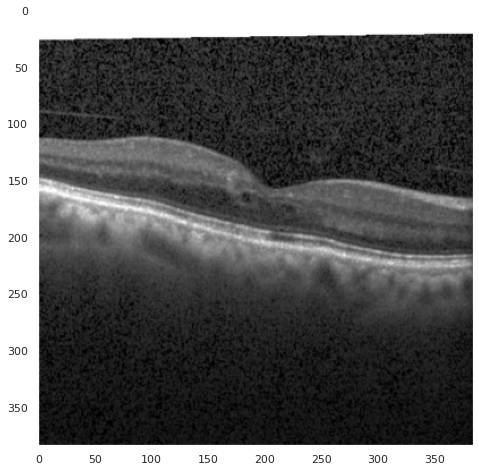

In [10]:
for images, _ in dataloaders[TRAIN]:
  img = images[0][0]
  plt.imshow(img, cmap = 'gray')
  plt.grid(None)
  plt.show()
  break

## Find the new distribution of the normalized dataset

In [11]:
mean, std = batch_mean_and_std(dataloaders[TRAIN])
print("mean and std: \n", mean, std)

100%|██████████| 4308/4308 [05:04<00:00, 14.15it/s]

mean and std: 
 tensor([-0.0009, -0.0009, -0.0009]) tensor([0.9991, 0.9991, 0.9991])


#### Much better!

Mean of around 0 and std of around 1!

Time to get ready to train the model!

## Utility functions

To visualize the dataset and the model's predictions

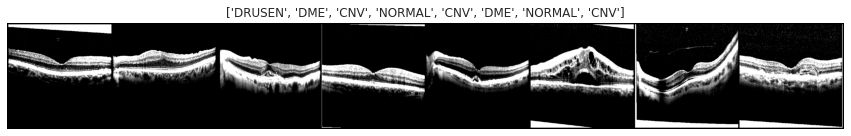

In [12]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    plt.figure(figsize=(15,15))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs, padding = 5)
    imshow(out, title=[class_names[x] for x in classes])

# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

In [13]:
def visualize_model_outputs(model, num_images=6):
    was_training = model.training
    
    # Set model for evaluation
    model.train(False)
    model.eval() 
    
    images_so_far = 0
    with torch.no_grad():
        for i, data in enumerate(dataloaders[TEST]):
            inputs, labels = data
            size = inputs.size()[0]
            
            if gpu_available:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            predicted_labels = [preds[j] for j in range(inputs.size()[0])]
            
            print("Ground truth:")
            show_databatch(inputs.data.cpu(), labels.data.cpu())
            print("Prediction:")
            show_databatch(inputs.data.cpu(), predicted_labels)
            
            del inputs, labels, outputs, preds, predicted_labels
            
            images_so_far += size
            if images_so_far >= num_images:
                break
        
    model.train(mode=was_training) # Revert model back to original training state

Helper function to find accuracy of model on test set

In [14]:
def eval_model(model, criterion):
    time_model = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    amount_of_test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    #don't update weights of the model when testing accuracy on test set
    with torch.no_grad():
        for i, data in enumerate(dataloaders[TEST]):
            #display batch number per ten batches 
            if i % 10 == 0:
                print("\rTest batch {}/{}".format(i, amount_of_test_batches), end='', flush=True)
          
            model.train(False)
            model.eval()
            inputs, labels = data

            if gpu_available:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)

            outputs = model(inputs)

            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)

            loss_test += loss
            acc_test += torch.sum(preds == labels)

            del inputs, labels, outputs, preds
        
    
    #average loss and accuracy over all images in test set 
    avg_loss = loss_test / len(image_datasets[TEST])
    avg_acc = acc_test / len(image_datasets[TEST])
    
    elapsed_time = time.time() - time_model
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

# Create ResNet18 model

![DenseNet architecture](https://www.researchgate.net/profile/Sajid-Iqbal-13/publication/336642248/figure/fig1/AS:839151377203201@1577080687133/Original-ResNet-18-Architecture.png)

In [15]:
#lets see the layers of the model
resnet18 = models.resnet18(pretrained = True)
print(resnet18)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
#find the classifier in_features and out_features to change the output of the model
#we only want to finetune the out_features (last layer of model), so we will change the layer
print(resnet18.fc)

Linear(in_features=512, out_features=1000, bias=True)


# Transfer learning

Transfer learning is where we take a pretrained model, in this case ResNet18, that is trained on a generic dataset, (ex. ImageNet), then we freeze the early layers of the model, and make the model learn new weights at the classifier end on a more specific task, which in this case is classifying Retinal OCT image data.

![](https://miro.medium.com/max/1400/1*D5S6ylZwUZAxj0lMyipZ2g.png)

This is how to create the model

In [17]:
# Freeze training for all layers, because we only want to change the output of the last layer
for param in resnet18.parameters():
    param.require_grad = False


num_features = resnet18.fc.in_features

#Change the output layer to the 4 classes that we are predicting
# Newly created modules have require_grad=True by default
resnet18.fc = nn.Linear(num_features, len(class_names)) # Replace the model classifier
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Now we have changed the final layer of our model and frozen the other layers of the model. Now for the model training!

We will also define our loss function (cross entropy) and the optimizer (Adam). 

The learning rate will start at 0.001 and StepLR will decrease it by a factor of 0.1 every 7 epochs 



In [18]:
if gpu_available:
    resnet18.cuda()
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.Adam(resnet18.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

## Model evaluation and visualization (before training)

Let's see how our model performs before any training

In [20]:
print("Test before training")
eval_model(resnet18, criterion)

Test before training
Evaluating model
----------
Test batch 120/121
Evaluation completed in 0m 8s
Avg loss (test): 0.2011
Avg acc (test): 0.2459
----------


As expected, not good accuracy

Ground truth:


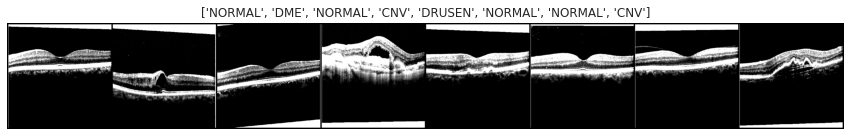

Prediction:


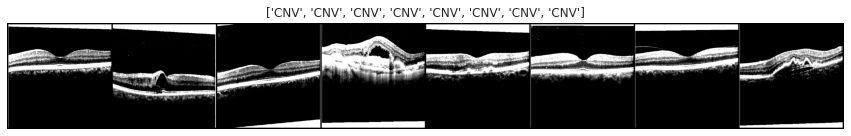

In [21]:
visualize_model_outputs(resnet18)

Time to train the model!

# Training the model

In [22]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[VAL])
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        model.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches), end='', flush=True)
                
            inputs, labels = data
            
            if gpu_available:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        avg_loss = loss_train / len(image_datasets[TRAIN])
        avg_acc = acc_train / len(image_datasets[TRAIN])
        
        model.train(False)
        model.eval()

        with torch.no_grad():    
          for i, data in enumerate(dataloaders[VAL]):
              print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                  
              inputs, labels = data
              
              if gpu_available:
                  inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
              else:
                  inputs, labels = Variable(inputs), Variable(labels)
              
              optimizer.zero_grad()
              
              outputs = model(inputs)
              
              _, preds = torch.max(outputs.data, 1)
              loss = criterion(outputs, labels)
              
              loss_val += loss.item()
              acc_val += torch.sum(preds == labels.data)
              
              del inputs, labels, outputs, preds
              torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / len(image_datasets[VAL])
        avg_acc_val = acc_val / len(image_datasets[VAL])
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(model.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
# this is how to train the model, but I will use the model I trained before hand
"""resnet18 = train_model(resnet18, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=1)

model_name = 'resnet18-OCT_Retina.pt'
#save model
torch.save(resnet18, model_name)
"""

Epoch 0/1
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Training batch 4300/4308
Validation batch 3/4
Epoch 0 result: 
Avg loss (train): 0.0270
Avg acc (train): 0.9280
Avg loss (val): 0.0027
Avg acc (val): 1.0000
----------


Training completed in 7m 47s
Best acc: 1.0000


### Load trained model

In [23]:
if gpu_available:
  resnet18 = torch.load("/content/resnet18-OCT_Retina.pt").cuda()
else:
  resnet18 = torch.load("/content/resnet18-OCT_Retina.pt", map_location = torch.device('cpu'))

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# Model evaluation and visualization (after training) on test set (99.59% acc)

Let's evaluate our model again 

In [24]:
eval_model(resnet18, criterion)

Evaluating model
----------
Test batch 120/121
Evaluation completed in 0m 7s
Avg loss (test): 0.0041
Avg acc (test): 0.9959
----------


Now that's a pretty good result!

Ground truth:


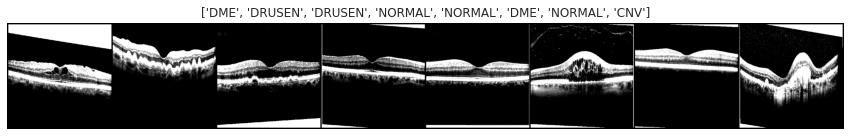

Prediction:


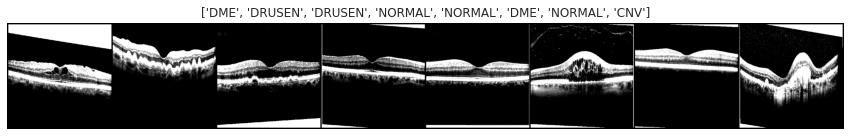

In [25]:
visualize_model_outputs(resnet18)

# Visualizing the output of the model with GradCAM and [OmniXAI](https://opensource.salesforce.com/OmniXAI/latest/index.html)


Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization, Selvaraju et al., https://arxiv.org/abs/1610.02391

What is OmniXAI [description from website](https://opensource.salesforce.com/OmniXAI/latest/index.html):

OmniXAI (short for Omni eXplainable AI) is a Python library for explainable AI (XAI), offering omni-way explainable AI and interpretable machine learning capabilities to address many pain points in explaining decisions made by machine learning models in practice. OmniXAI aims to be a one-stop comprehensive library that makes explainable AI easy for data scientists, ML researchers and practitioners who need explanation for various types of data, models and explanation methods at different stages of ML process


Grad-CAM: Gradient-weighted Class Activation Mapping is a way for visualizing the output of CNN-based models, and I will use a package called pytorch_grad_cam made by Jacob Gil from [Github](https://github.com/jacobgil/pytorch-grad-cam)



Necessary packages

In [26]:
pip install -U omnixai omnixai[vision] kaleido

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 487 kB 9.3 MB/s 
     |████████████████████████████████| 79.9 MB 1.2 MB/s 
     |████████████████████████████████| 756 kB 63.4 MB/s 
     |████████████████████████████████| 275 kB 62.1 MB/s 
     |████████████████████████████████| 569 kB 38.6 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 1.6 MB 57.0 MB/s 
     |████████████████████████████████| 76 kB 6.9 MB/s 
     |████████████████████████████████| 115 kB 76.2 MB/s 
     |████████████████████████████████| 52 kB 1.6 MB/s 
  Created wheel for hnswlib: filename=hnswlib-0.6.2-cp37-cp37m-linux_x86_64.whl size=1470447 sha256=d465c094d6cb0701770b6947732c7cad60a9ca5671ce4a25df53eacc06ee0ff9
  Stored in directory: /root/.cache/pip/wheels/67/01/80/9805daef8cd398ceb20003af220f77c4689ca

In [27]:
from PIL import Image as PilImage

from omnixai.data.image import Image
from omnixai.explainers.vision.specific.gradcam.pytorch.gradcam import GradCAM
import cv2

## Get an image to use GradCAM on

Put into one code cell to make it easier to re-run



Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Original image of patient with DRUSEN




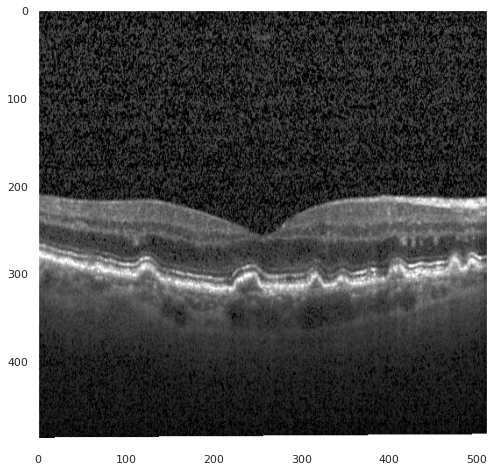



GradCAM





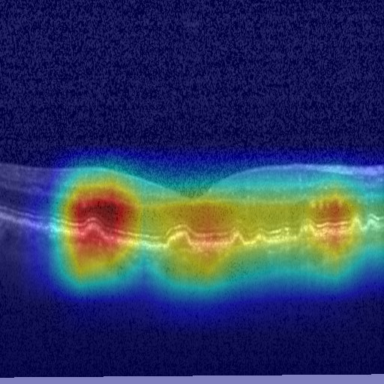
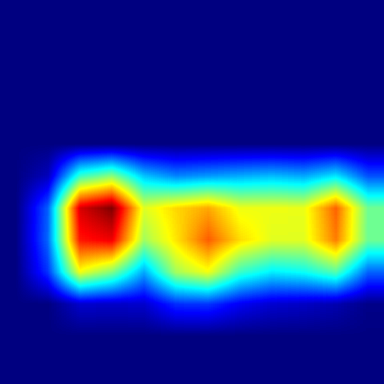

In [28]:
# Load the test image
random_folder = random.choice(os.listdir("/content/data/OCT2017 /test"))
random_image = random.choice(os.listdir(os.path.join("/content/data/OCT2017 /test", random_folder)))

img = Image(PilImage.open(os.path.join("/content/data/OCT2017 /test/", random_folder, random_image)).convert('RGB'))

transform = transforms.Compose([
      transforms.Resize([384,384]),
      transforms.ToTensor(),
      transforms.Normalize([0.1933, 0.1933, 0.1933], [0.2210, 0.2210, 0.2210])
    ])
preprocess = lambda imgs: torch.stack([transform(img.to_pil()) for img in imgs])

#Create GradCAM
explainer = GradCAM(
    model=resnet18,
    #layer we are looking at the gradients of for GradCAM
    target_layer=resnet18.layer4[-1],
    #dataloader is already preprocessed
    preprocess_function = preprocess,
    mode = 'classification'
)
# Explain the top label
explanations = explainer.explain(img)
print(f"Original image of patient with {random_folder}")
print("\n")
plt.imshow(cv2.imread(os.path.join("/content/data/OCT2017 /test/", random_folder, random_image)))
plt.grid(None)
plt.show()
print("\n")


print("GradCAM")
print("\n")
explanations.ipython_plot(index=0, class_names=class_names)